In [1]:
#Special
from Bio.PDB import *
import pynmrstar

#Core numerical
import numpy as np
import pandas as pd

#Visuals
import nglview as nv
import matplotlib.pyplot as plt
import seaborn as sns

#Auxillary
from glob import glob
import os
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
    

# Residue-specific statistical analysis of backbone 1H and 15N chemical shifts 

The data was prepared in the previous notebook `H-bonds.ipynb`. H-bonds are identified with DSSP and lengths are measured with functions from `Bio.PDB` module

## Reading the data

In [2]:
wdir='~/sciebo/PDB analysis/'

In [3]:
df = pd.read_csv(wdir+'/shifts_H-bond_lens.tab', sep='\t')

df['H_bond_min'] = df[['H_bond_1', 'H_bond_2', 'H_bond_11', 'H_bond_12']].apply(min, axis=1)
df = df.loc[df['H_bond_min'] < 3.9] ## discarding residues with unbelivably long minimal N--O distance

#df.drop(df.loc[df.SS=='B'].index, inplace=True)
df_15N = df.groupby(by='Atom_ID').get_group('N')
df_1H = df.groupby(by='Atom_ID').get_group('H')

In [4]:
df

,PDB_ID,Seq_ID,level_0,index,Unnamed: 0,Unnamed: 0.1,CHAIN,#,AA,SS,...,O-NH2_En,Comp_ID,Atom_ID,Val,BMRB_ID,H_bond_1,H_bond_2,H_bond_11,H_bond_12,H_bond_min
0,1axh,5.0,0,0,0,10,A,5,I,B,...,-0.4,ILE,N,122.800,5702,3.182717,7.357613,2.879526,4.828830,2.879526
1,1axh,5.0,1,1,1,11,A,5,I,B,...,-0.4,ILE,H,9.190,5702,3.182717,7.357613,2.879526,4.828830,2.879526
2,1axh,5.0,2,2,2,12,A,5,I,B,...,-0.4,ILE,CA,60.100,5702,3.182717,7.357613,2.879526,4.828830,2.879526
3,1axh,5.0,3,3,3,13,A,5,I,B,...,-0.4,ILE,CB,40.200,5702,3.182717,7.357613,2.879526,4.828830,2.879526
4,1axh,10.0,4,4,4,27,A,10,P,B,...,-0.1,PRO,CA,63.100,5702,2.934207,2.934207,6.157717,5.939747,2.934207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190141,2lkt,103.0,190141,190141,128,347,A,103,K,E,...,-0.2,LYS,N,120.534,18012,6.671101,3.785864,5.028546,6.629341,3.785864
190142,2lkt,104.0,190142,190142,129,348,A,104,M,E,...,-0.0,MET,H,8.544,18012,3.273564,4.796675,2.914398,9.007488,2.914398
190143,2lkt,104.0,190143,190143,130,349,A,104,M,E,...,-0.0,MET,CA,54.276,18012,3.273564,4.796675,2.914398,9.007488,2.914398
190144,2lkt,104.0,190144,190144,131,350,A,104,M,E,...,-0.0,MET,CB,36.695,18012,3.273564,4.796675,2.914398,9.007488,2.914398


In [5]:
res_list = list(df_15N.Comp_ID.unique())
for res in ['ASH', 'CYS', 'PRO']:
    if res in res_list:
        res_list.remove(res)
res_list.sort()

In [6]:
# Statistics
#How many PDBs are eventually included into the table
print(f"Data taken from {df.loc[df['H_bond_1'].notna()].set_index('PDB_ID').index.unique().shape[0]} PDBs")
res_groups = df_15N.groupby(by='Comp_ID')
for res in res_list:
    N = res_groups.get_group(res).shape[0]
    print(f"{res}: N={N}")

Data taken from 1608 PDBs
ALA: N=1787
ARG: N=1717
ASN: N=835
ASP: N=1065
GLN: N=1106
GLU: N=2016
GLY: N=1437
HIS: N=726
ILE: N=3165
LEU: N=3534
LYS: N=2103
MET: N=635
PHE: N=2064
SER: N=1569
THR: N=2340
TRP: N=639
TYR: N=1799
VAL: N=4646


## Chem shift vs. H-bond length 

### Nitrogens

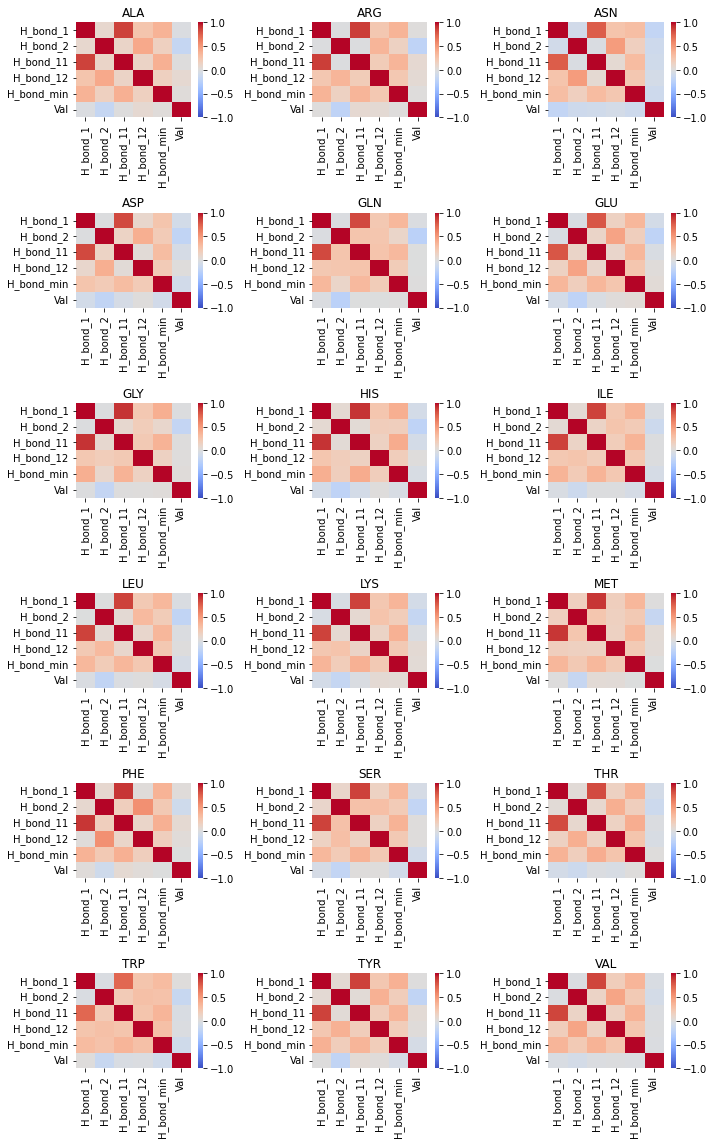

In [7]:
res_groups = df_15N.groupby(by='Comp_ID')

res_list = list(df_15N.Comp_ID.unique())
for res in ['ASH', 'CYS', 'PRO']:
    if res in res_list:
        res_list.remove(res)
res_list.sort()

fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(10, 16))
for res, ax in zip(res_list, axs.ravel()):
    df_15N_Res = res_groups.get_group(res)

    pears=np.round(df_15N_Res[['Val', 'H_bond_min']].corr().iloc[0,1], 3)

    sb_cor = df_15N_Res[['H_bond_1', 'H_bond_2', 'H_bond_11', 'H_bond_12','H_bond_min', 'Val']].corr()

    #import seaborn as sns 
    cor_map = sns.heatmap(sb_cor, ax=ax, vmin=-1, vmax=1, cmap='coolwarm')
    ax.set_title(res)
fig.tight_layout()

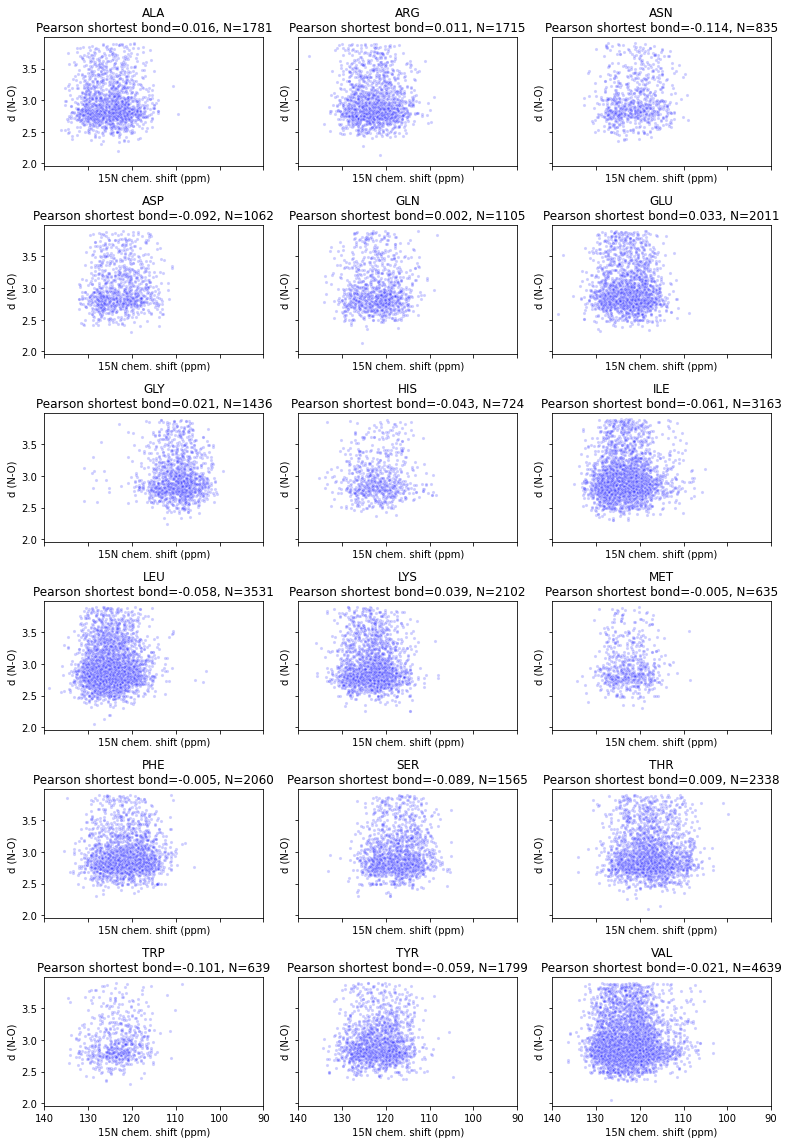

In [8]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(11,16), sharex=True, sharey=True)

res_list = list(df_15N.Comp_ID.unique())
for res in ['ASH', 'CYS', 'PRO']:
    if res in res_list:
        res_list.remove(res)
res_list.sort()

res_groups = df_15N.groupby(by='Comp_ID')

for res, ax in zip(res_list, axs.ravel()):
    
    df_15N_Res = res_groups.get_group(res)
    
    pears=np.round(df_15N_Res[['Val', 'H_bond_min']].corr().iloc[0,1], 3)
    ax.scatter(df_15N_Res.Val, df_15N_Res.H_bond_min, alpha=0.2, s=10, c='b', edgecolors='white')

    
    ax.set_title(res+"\n"+f"Pearson shortest bond={pears}, N={len(df_15N_Res.dropna())}")
    ax.set_xlim(140, 90)
    #ax.set_ylim(2.0, 3.5)
    ax.set_xlabel('15N chem. shift (ppm)')
    ax.set_ylabel('d (N-O)')
    
fig.tight_layout()
    #print(res, pears)
fig.savefig('C:/Users/Krairy/OneDrive/PhD/H-bonds/Shifts_H-bonds_by_DSSP_Shortest_15N.jpeg', dpi=200)

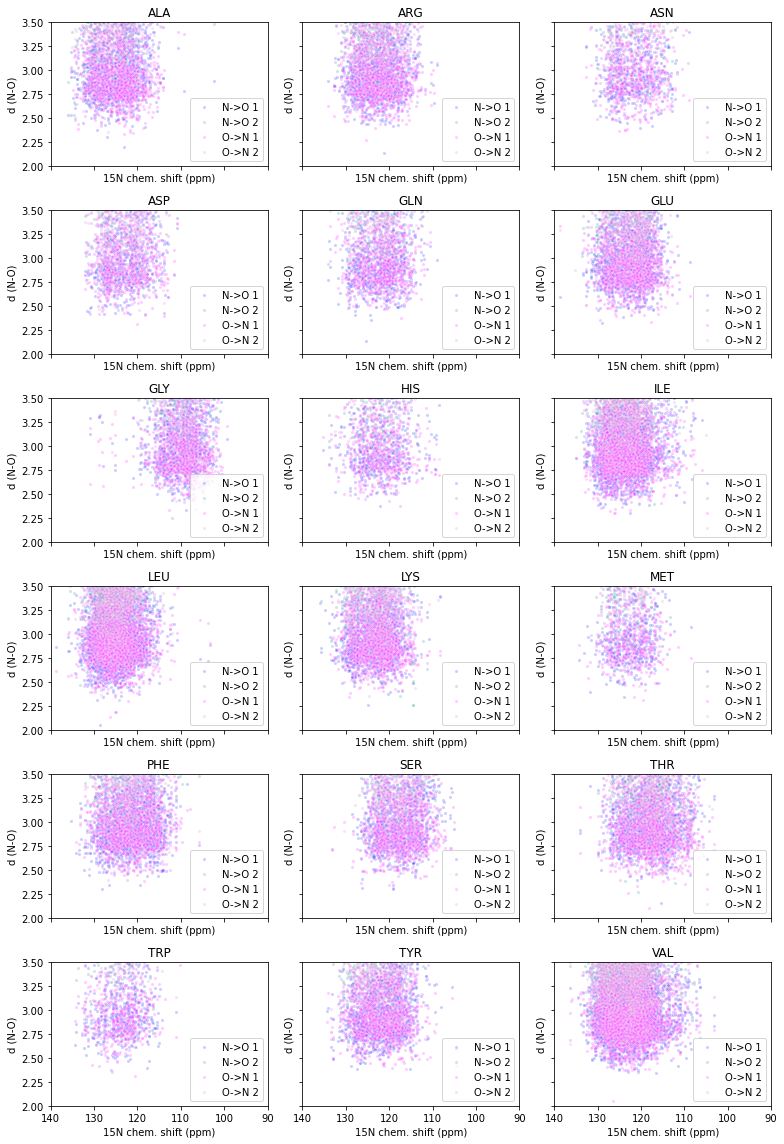

In [9]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(11,16), sharex=True, sharey=True)

res_list = list(df_15N.Comp_ID.unique())
for res in ['ASH', 'CYS', 'PRO']:
    if res in res_list:
        res_list.remove(res)
res_list.sort()

res_groups = df_15N.groupby(by='Comp_ID')
for res, ax in zip(res_list, axs.ravel()):
    
    df_15N_Res = res_groups.get_group(res)

    ax.scatter(df_15N_Res.Val, df_15N_Res.H_bond_1, alpha=0.2, s=10, c='b', edgecolors='white', 
              label='N->O 1') # donor
    ax.scatter(df_15N_Res.Val, df_15N_Res.H_bond_2, alpha=0.2, s=10, c='teal', edgecolors='white', 
              label='N->O 2') # donor
    ax.scatter(df_15N_Res.Val, df_15N_Res.H_bond_11, alpha=0.2, s=10, c='magenta', edgecolors='white', 
              label='O->N 1') # acceptor
    ax.scatter(df_15N_Res.Val, df_15N_Res.H_bond_12, alpha=0.2, s=10, c='orchid', edgecolors='white', 
              label='O->N 2') # acceptor

    ax.legend(loc='lower right')
    ax.set_title(res)
    ax.set_xlim(140, 90)
    ax.set_ylim(2.0, 3.5)
    ax.set_xlabel('15N chem. shift (ppm)')
    ax.set_ylabel('d (N-O)')
    
fig.tight_layout()
    #print(res, pears)
fig.savefig('C:/Users/Krairy/OneDrive/PhD/H-bonds/Shifts_H-bonds_by_DSSP_All.jpeg', dpi=200)

### Protons

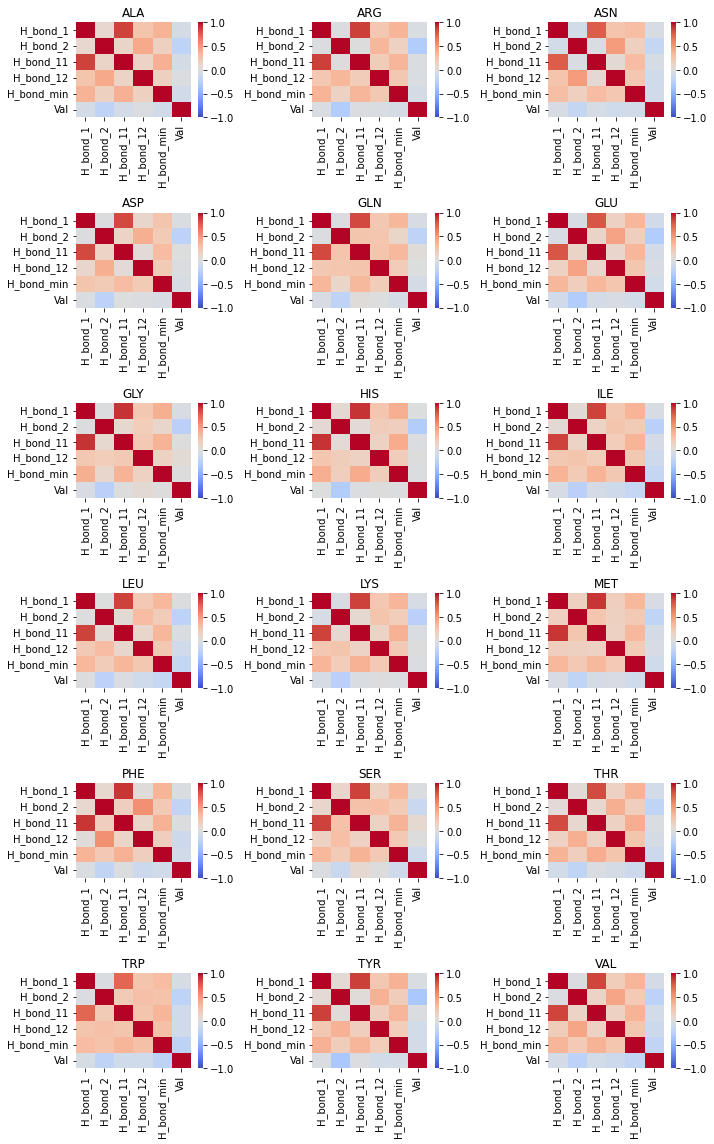

In [10]:
res_groups = df_1H.groupby(by='Comp_ID')

res_list = list(df_1H.Comp_ID.unique())
for res in ['ASH', 'CYS', 'PRO']:
    if res in res_list:
        res_list.remove(res)
res_list.sort()

fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(10, 16))
for res, ax in zip(res_list, axs.ravel()):
    df_1H_Res = res_groups.get_group(res)
    
    pears=np.round(df_1H_Res[['Val', 'H_bond_min']].corr().iloc[0,1], 3)

    sb_cor = df_1H_Res[['H_bond_1', 'H_bond_2', 'H_bond_11', 'H_bond_12','H_bond_min', 'Val']].corr()

    #import seaborn as sns 
    cor_map = sns.heatmap(sb_cor, ax=ax, vmin=-1, vmax=1, cmap='coolwarm')
    ax.set_title(res)
fig.tight_layout()

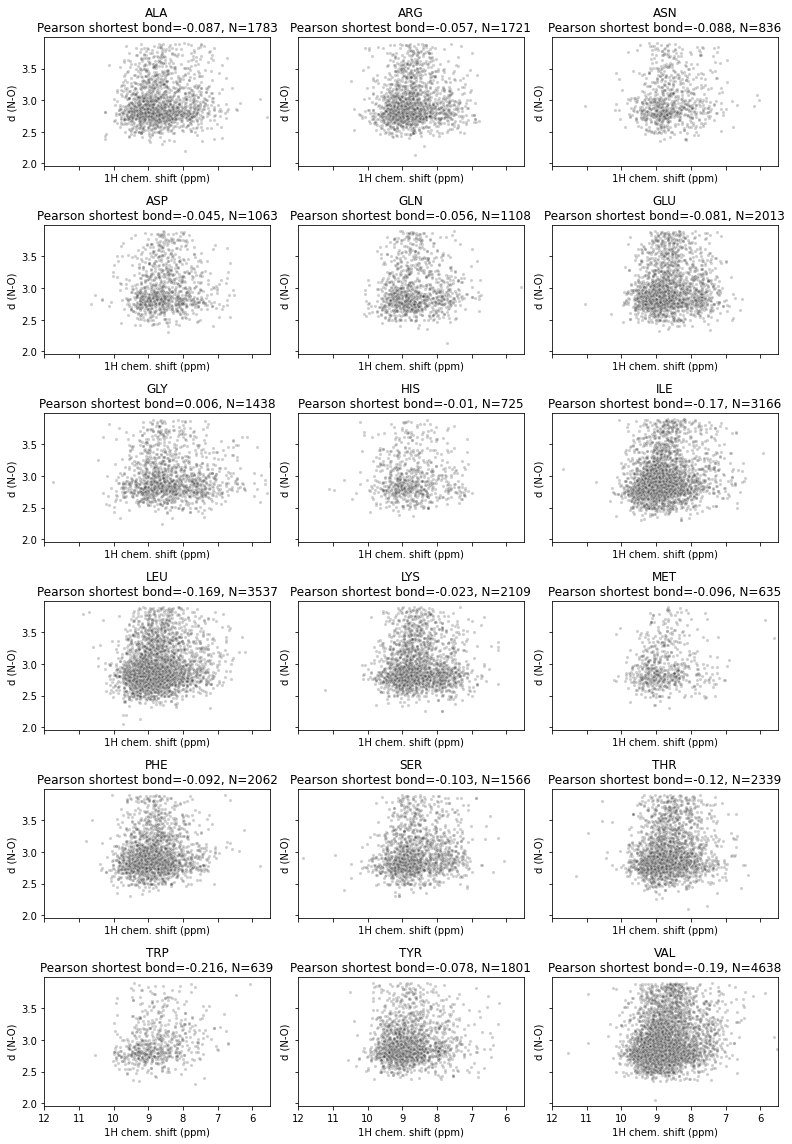

In [11]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(11,16), sharex=True, sharey=True)

res_list = list(df_1H.Comp_ID.unique())
for res in ['ASH', 'CYS', 'PRO']:
    if res in res_list:
        res_list.remove(res)
res_list.sort()

res_groups = df_1H.groupby(by='Comp_ID')
for res, ax in zip(res_list, axs.ravel()):
    
    df_1H_Res = res_groups.get_group(res)    
    pears=np.round(df_1H_Res[['Val', 'H_bond_min']].corr().iloc[0,1], 3)
    ax.scatter(df_1H_Res.Val, df_1H_Res.H_bond_min, alpha=0.2, s=10, c='k', edgecolors='white')

    
    ax.set_title(res+"\n"+f"Pearson shortest bond={pears}, N={len(df_1H_Res.dropna())}")
    ax.set_xlim(12, 5.5)
    #ax.set_ylim(2.0, 3.5)
    ax.set_xlabel('1H chem. shift (ppm)')
    ax.set_ylabel('d (N-O)')
    
fig.tight_layout()
    #print(res, pears)
fig.savefig('C:/Users/Krairy/OneDrive/PhD/H-bonds/Shifts_H-bonds_by_DSSP_Shortest_1H.jpeg', dpi=200)

## By energy

### Nitrogens

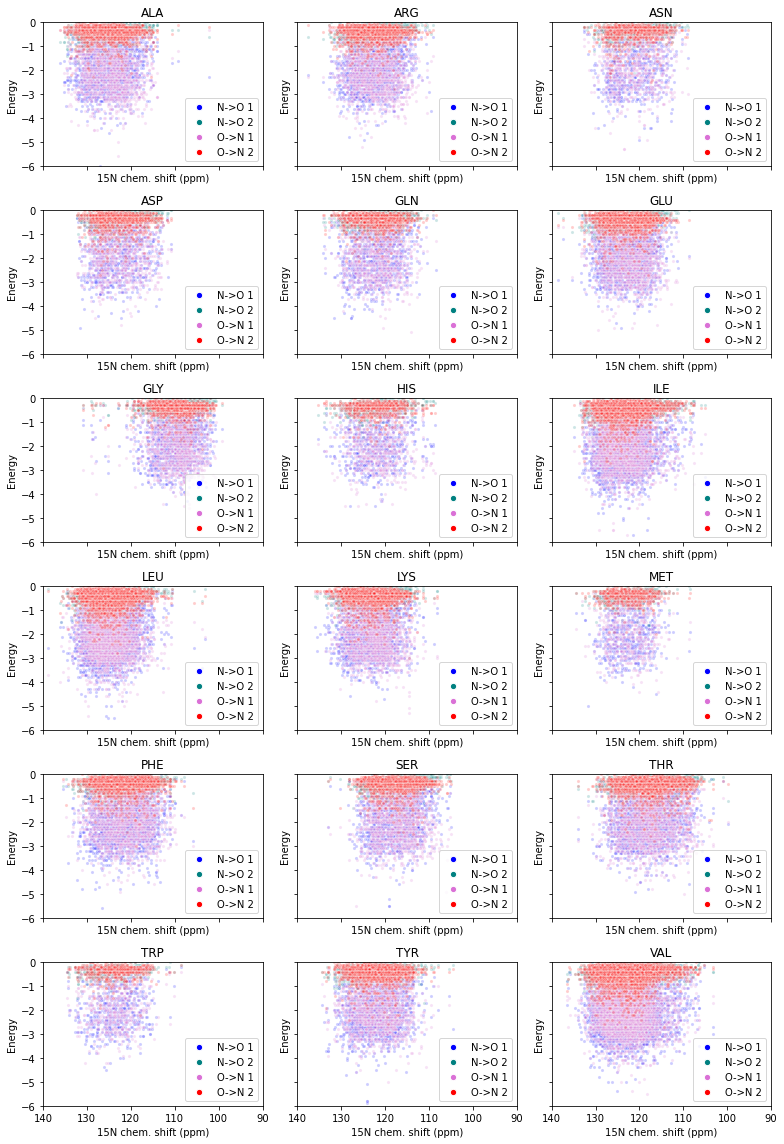

In [12]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(11,16), sharex=True, sharey=True)

res_list = list(df_15N.Comp_ID.unique())
for res in ['ASH', 'CYS', 'PRO']:
    if res in res_list:
        res_list.remove(res)
res_list.sort()

res_groups = df_15N.groupby(by='Comp_ID')
for res, ax in zip(res_list, axs.ravel()):
    
    df_15N_Res = res_groups.get_group(res)

    ax.scatter(df_15N_Res.Val, df_15N_Res['NH-O1_En'], alpha=0.2, s=10, c='b', edgecolors='white') # as donor
    ax.scatter(df_15N_Res.Val, df_15N_Res['NH-O2_En'], alpha=0.2, s=10, c='teal', edgecolors='white') # as donor
    ax.scatter(df_15N_Res.Val, df_15N_Res['O-NH1_En'], alpha=0.2, s=10, c='orchid', edgecolors='white') # as acceptor
    ax.scatter(df_15N_Res.Val, df_15N_Res['O-NH2_En'], alpha=0.2, s=10, c='red', edgecolors='white') # as acceptor

    # for the legend
    ax.scatter([-100], [100], alpha=1, s=40, c='b', edgecolors='white', label='N->O 1') 
    ax.scatter([-100], [100], alpha=1, s=40, c='teal', edgecolors='white', label='N->O 2') 
    ax.scatter([-100], [100], alpha=1, s=40, c='orchid', edgecolors='white', label='O->N 1') 
    ax.scatter([-100], [100], alpha=1, s=40, c='red', edgecolors='white', label='O->N 2') 
    
    ax.set_title(res)
    ax.set_xlim(140, 90)
    ax.set_ylim(-6, 0)
    ax.legend(loc='lower right')
    ax.set_xlabel('15N chem. shift (ppm)')
    ax.set_ylabel('Energy')
    
fig.tight_layout()
    #print(res, pears)
fig.savefig('C:/Users/Krairy/OneDrive/PhD/H-bonds/Shifts_H-bonds_by_DSSP_Energy_15N.jpeg', dpi=200)

### Protons

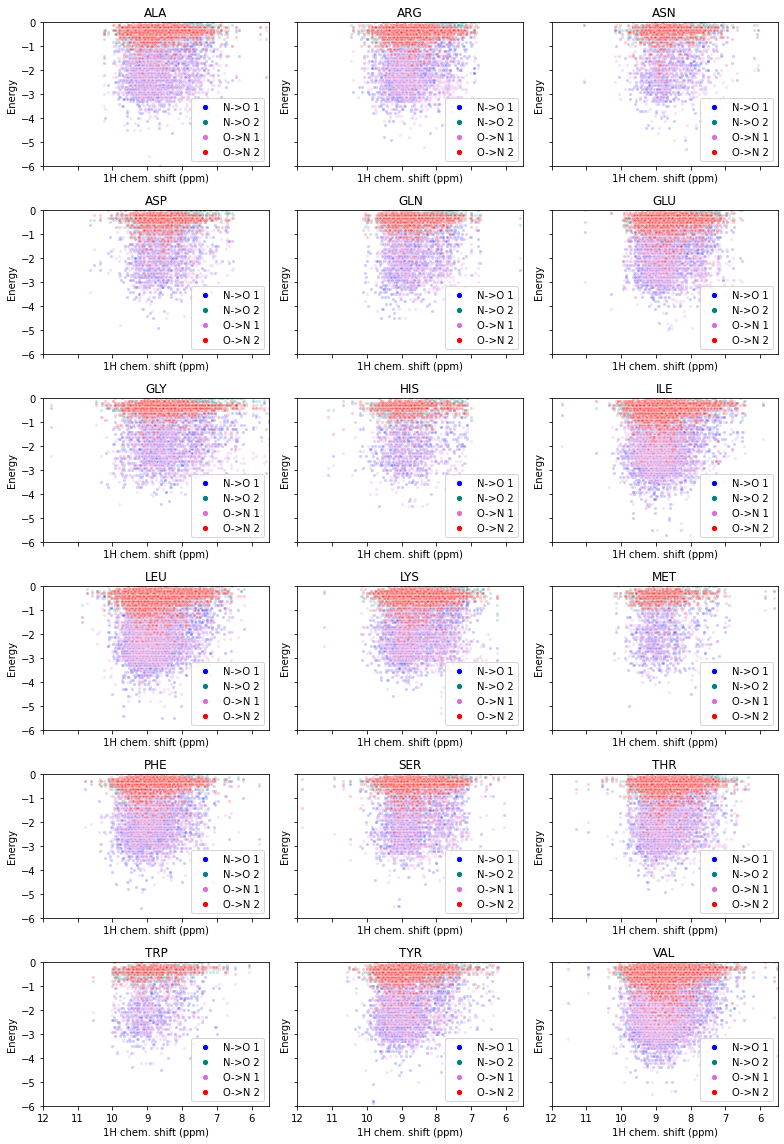

In [13]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(11,16), sharex=True, sharey=True)

res_list = list(df_1H.Comp_ID.unique())
for res in ['ASH', 'CYS', 'PRO']:
    if res in res_list:
        res_list.remove(res)
res_list.sort()

res_groups = df_1H.groupby(by='Comp_ID')
for res, ax in zip(res_list, axs.ravel()):
    
    df_1H_Res = res_groups.get_group(res)

    ax.scatter(df_1H_Res.Val, df_1H_Res['NH-O1_En'], alpha=0.2, s=10, c='b', edgecolors='white') # as donor
    ax.scatter(df_1H_Res.Val, df_1H_Res['NH-O2_En'], alpha=0.2, s=10, c='teal', edgecolors='white') # as donor
    ax.scatter(df_1H_Res.Val, df_1H_Res['O-NH1_En'], alpha=0.2, s=10, c='orchid', edgecolors='white') # as acceptor
    ax.scatter(df_1H_Res.Val, df_1H_Res['O-NH2_En'], alpha=0.2, s=10, c='red', edgecolors='white') # as acceptor

    # for the legend
    ax.scatter([-100], [100], alpha=1, s=40, c='b', edgecolors='white', label='N->O 1') 
    ax.scatter([-100], [100], alpha=1, s=40, c='teal', edgecolors='white', label='N->O 2') 
    ax.scatter([-100], [100], alpha=1, s=40, c='orchid', edgecolors='white', label='O->N 1') 
    ax.scatter([-100], [100], alpha=1, s=40, c='red', edgecolors='white', label='O->N 2') 
    ax.legend(loc=4)
    
    ax.set_title(res)
    ax.set_xlim(12, 5.5)
    ax.set_ylim(-6, 0)
    ax.set_xlabel('1H chem. shift (ppm)')
    ax.set_ylabel('Energy')
    
fig.tight_layout()
    #print(res, pears)
fig.savefig('C:/Users/Krairy/OneDrive/PhD/H-bonds/Shifts_H-bonds_by_DSSP_Energy_1H.jpeg', dpi=200)

## Correlation maps

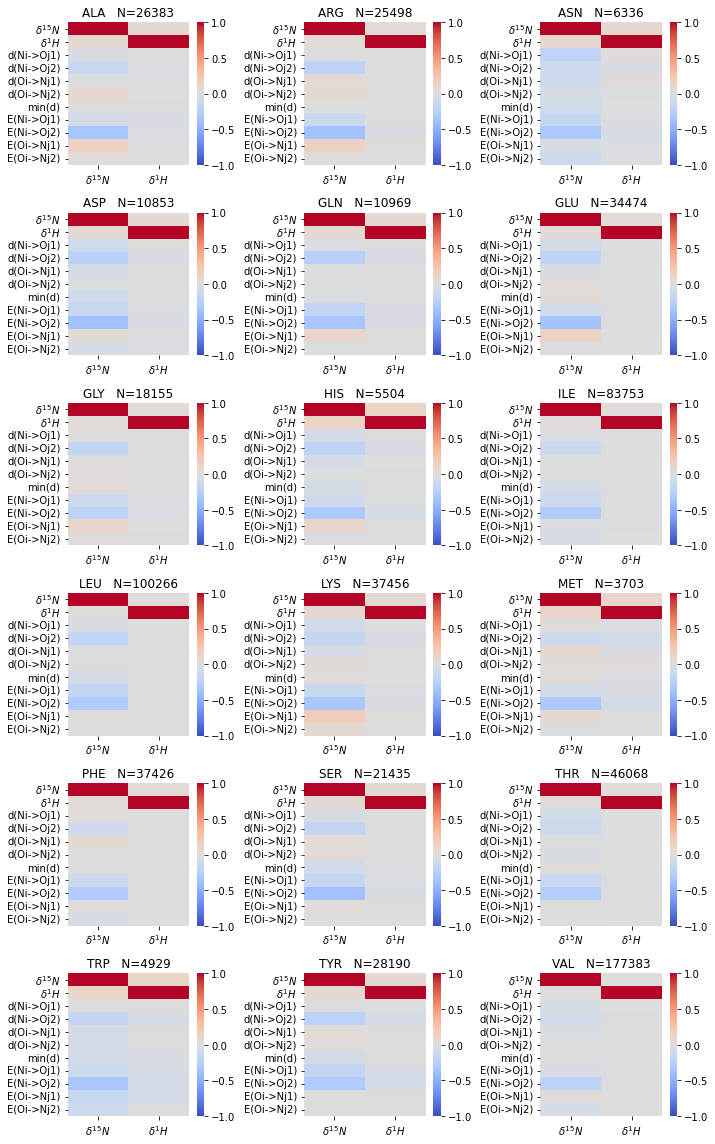

In [14]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(10, 16))

for res, ax in zip(res_list, axs.ravel()):
    res_groups = df.groupby(by='Comp_ID')
    df_res = res_groups.get_group(res).set_index('#')
    df_res_H = df_res.groupby(by='Atom_ID').get_group('H')
    df_res_N = df_res.groupby(by='Atom_ID').get_group('N')

    df_HN_Res = pd.merge(left=df_res_N[['PDB_ID', 'Seq_ID', 'AA', 'SS', 'PHI', 'PSI', 'NH-O1_idx', 'NH-O1_En', 'O-NH1_idx',
       'O-NH1_En', 'NH-O2_idx', 'NH-O2_En', 'O-NH2_idx', 'O-NH2_En', 'Comp_ID',
        'Val', 'BMRB_ID', 'H_bond_1', 'H_bond_2', 'H_bond_11',
       'H_bond_12', 'H_bond_min']], 
         right=df_res_H[['Val']], left_index=True, right_index=True, suffixes=('_N', '_H'))
    
    corr_matrix = df_HN_Res[['Val_N', 'Val_H', 'H_bond_1', 'H_bond_2', 'H_bond_11', 'H_bond_12', 'H_bond_min',
       'NH-O1_En', 'NH-O2_En', 'O-NH1_En', 'O-NH2_En']].corr()

    sns.heatmap(corr_matrix.iloc[:, :2], xticklabels=['$\delta ^{15}N$', '$\delta ^1H$'],
                yticklabels=['$\delta ^{15}N$', '$\delta ^1H$', 'd(Ni->Oj1)', 'd(Ni->Oj2)', 'd(Oi->Nj1)', 'd(Oi->Nj2)', 'min(d)', 
                            'E(Ni->Oj1)', 'E(Ni->Oj2)', 'E(Oi->Nj1)', 'E(Oi->Nj2)'],           
            vmin=-1, vmax=1, cmap='coolwarm', ax=ax)
    
    ax.set_title(res+'   N='+str(df_HN_Res.shape[0]))

fig.tight_layout()
fig.savefig('C:/Users/Krairy/OneDrive/PhD/H-bonds/Correlations.png', dpi=200)